In [1]:
import numpy as np
import pandas as pd
import random
import os
import gc
import math
import optuna
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.manifold import TSNE
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from geomloss import SamplesLoss
from torch.autograd import Function
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.nn.functional import normalize
#from torchmetrics.classification import BinaryAccuracyS
from torchmetrics.classification import BinaryF1Score,BinaryAccuracy
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
torch.manual_seed(42)

/home/ahmad/envs/RL/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [3]:
def get_data(data_type,file_num):

    if(data_type=='train'):
        data=pd.read_csv(f"Dataset/IHDP_a/ihdp_npci_train_{file_num}.csv")
        #data=pd.read_csv(f"Data/ihdp_npci_train_{file_num}.csv",index_col=False)
    else:
        data = pd.read_csv(f"Dataset/IHDP_a/ihdp_npci_test_{file_num}.csv")
        #data = pd.read_csv(f"Data/ihdp_npci_test_{file_num}.csv",index_col=False)

    x_data=pd.concat([data.iloc[:,0], data.iloc[:, 1:30]], axis = 1)
 
   
    y_data=data.iloc[:, 1]
   
    
    return x_data,y_data

In [4]:
def get_data_2(data_type,file_num):

    if(data_type=='train'):
        #data=pd.read_csv(f"Dataset/IHDP_a/ihdp_npci_train_{file_num}.csv")
        data=pd.read_csv(f"Data/ihdp_npci_train_{file_num}.csv",index_col=False)
    else:
        #data = pd.read_csv(f"Dataset/IHDP_a/ihdp_npci_test_{file_num}.csv")
        data = pd.read_csv(f"Data/ihdp_npci_test_{file_num}.csv",index_col=False)

   
    x_data=data
  
    del x_data[x_data.columns[0]]
   
    y_data=data.iloc[:, 1]
    
    return x_data,y_data

In [5]:
def get_dataloader(x_data,y_data,batch_size):

    x_train_sr=x_data[x_data['treatment']==0]
    y_train_sr=y_data[x_data['treatment']==0]
    x_train_tr=x_data[x_data['treatment']==1]
    y_train_tr=y_data[x_data['treatment']==1]


    train_data_sr = Data(np.array(x_train_sr), np.array(y_train_sr))
    train_dataloader_sr = DataLoader(dataset=train_data_sr, batch_size=batch_size)

    train_data_tr = Data(np.array(x_train_tr), np.array(y_train_tr))
    train_dataloader_tr = DataLoader(dataset=train_data_tr, batch_size=batch_size)


    return train_dataloader_sr, train_dataloader_tr

In [6]:
def regression_loss(concat_true, concat_pred):
    #computes a standard MSE loss for TARNet
    y_true = concat_true[:, 0] #get individual vectors
    t_true = concat_true[:, 1]

    y0_pred = concat_pred[:, 0]
    y1_pred = concat_pred[:, 1]

    #Each head outputs a prediction for both potential outcomes
    #We use t_true as a switch to only calculate the factual loss
    loss0 = torch.sum((1. - t_true) * torch.square(y_true - y0_pred))
    loss1 = torch.sum(t_true * torch.square(y_true - y1_pred))
    #note Shi uses tf.reduce_sum for her losses instead of tf.reduce_mean.
    #They should be equivalent but it's possible that having larger gradients accelerates convergence.
    #You can always try changing it!
    return loss0 + loss1

def coral_loss(source, target,lambda_):
    d = source.shape[1]

    # source covariance
    xm = torch.mean(source, 0, keepdim=True) - source
    xc = (xm.t() @ xm) +(lambda_ * torch.eye(xm.shape[1]))
    

    # target covariance
    xmt = torch.mean(target, 0, keepdim=True) - target
    xct = (xmt.t() @ xmt)+(lambda_ * torch.eye(xmt.shape[1]))

    # frobenius norm between source and target
    loss = torch.mean(torch.mul((xc - xct), (xc - xct)))
    loss = loss/(4*d*d)

    return loss

In [7]:
def loss_cal(X_data,y_data,net,alpha,lambda_):
    b_accu = BinaryAccuracy()
    b_f1=BinaryF1Score()
    
    x_train_sr=X_data[X_data['treatment']==0]
    y_train_sr=y_data[X_data['treatment']==0]
    x_train_tr=X_data[X_data['treatment']==1]
    y_train_tr=y_data[X_data['treatment']==1]
    xs_t=x_train_sr.iloc[:,0].to_numpy()
    xt_t=x_train_tr.iloc[:,0].to_numpy()
    
    
    xs=x_train_sr.iloc[:,5:30].to_numpy()
    xt=x_train_tr.iloc[:,5:30].to_numpy()
    xs_t=torch.from_numpy(xs_t.astype(np.float32))
    xt_t=torch.from_numpy(xt_t.astype(np.float32))
    y_train_sr=y_train_sr.to_numpy()
    y_train_tr=y_train_tr.to_numpy()
    xs=torch.from_numpy(xs.astype(np.float32))
    xt=torch.from_numpy(xt.astype(np.float32))
    
    y_train_sr=torch.from_numpy(y_train_sr.astype(np.float32))
    y_train_tr=torch.from_numpy(y_train_tr.astype(np.float32))
    
    
    input_data=torch.cat((xs,xt),0)
    true_y=torch.unsqueeze(torch.cat((y_train_sr,y_train_tr),0), dim=1)
    true_t=torch.unsqueeze(torch.cat((xs_t,xt_t),0), dim=1)
    
    
    concat_true=torch.cat((true_y,true_t),1)
    concat_pred,phi=net(input_data,alpha)
    loss=regression_loss(concat_true, concat_pred)
    
    cor_loss=coral_loss(phi[0:xs_t.shape[0],:],phi[xs_t.shape[0]:,:],lambda_)
    
    
    
    #t_actual=torch.cat((xs_t.type(torch.LongTensor),xt_t.type(torch.LongTensor)),0)
    
    #domain_loss=criterion(d_out, t_actual)
    
    #predicted = torch.argmax(d_out, dim=1)
    
    
    
    
    return loss.item(),cor_loss.item()

In [8]:
def objective(trial,i):

    params = {
          'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
          'optimizer': trial.suggest_categorical("optimizer", ["Adam", "SGD"]),
          'batch_size':trial.suggest_int('batch_size', 8, 256),
          'RL11':trial.suggest_int('RL11', 16, 512),
          'RL21': trial.suggest_int('RL21', 16, 512),
          'RL32': trial.suggest_int('RL32', 16, 512),
          'RG012':trial.suggest_int('RG012', 16, 512),
        'RG022':trial.suggest_int('RG022', 16, 512),
        'RG112':trial.suggest_int('RG112', 16, 512),
        'RG122':trial.suggest_int('RG122', 16, 512),
        'CL12':trial.suggest_int('CL12', 16, 512),
        'CL22':trial.suggest_int('CL22', 16, 512)
          
          }

    model = TarNet(params)

    pehe,model= train_evaluate(params, model, trial,i)

    return pehe

In [9]:
def pehe_loss_2(y1_pred,y0_pred,mu_1,mu_0):
    a=((mu_1-mu_0)-(y1_pred-y0_pred))
    er1=torch.square(a)
    #pehe=torch.mean(er1)
    pehe=torch.sqrt(torch.mean(er1))
    return pehe

In [10]:
# PEHE evaluation
def cal_pehe(data,y,model, data_tr,alpha=0.5):
    #data,y=get_data('test',i)

    data=data.to_numpy()
    data=torch.from_numpy(data.astype(np.float32))
    #training data
    data_tr=data_tr.to_numpy()
    data_tr=torch.from_numpy(data_tr.astype(np.float32))



    concat_pred,phi=model(data[:,5:30])
    
    #training data
    can_pr,phi_tr=model(data_tr[:,5:30])
    clf = LogisticRegression(random_state=0).fit(phi_tr.detach().numpy(), data_tr[:,0].detach().numpy())
    prob=clf.predict_proba(phi_tr.detach().numpy())
    
    #Untranformed data
    #clf = LogisticRegression(random_state=0).fit(np.array(data_tr.iloc[:,5:30]), np.array(data_tr.iloc[:,0]))
    #prob=clf.predict_proba(np.array(data_tr.iloc[:,5:30]))
    
    
    
    cate_pred=concat_pred[:,1]-concat_pred[:,0]
    #cate_pred=y1-y0
    cate_true=data[:,4]-data[:,3] #Hill's noiseless true values
    cate_err=torch.mean( torch.square( ( (cate_true) - (cate_pred) ) ) )
    return torch.sqrt(cate_err).item(),prob

In [11]:
def cal_pehe_nn(data,y,model, alpha=0.5):
        
        datat=data.to_numpy()
        datat=torch.from_numpy(datat.astype(np.float32))
        df_datac=data[data['treatment']==0]
        df_datat=data[data['treatment']==1]
        
        concat_pred,d_out,phi=model(datat[:,5:30])
        PhiC, PhiT = torch.split(phi, [torch.sum(datat[:,0] == 0), torch.sum(datat[:,0] == 1)], dim=0)
        dists = torch.sqrt(torch.cdist(PhiC, PhiT))
        
        c_index=torch.argmin(dists, dim=0).tolist()
        t_index=torch.argmin(dists, dim=1).tolist()
    
        yT_nn=df_datac.iloc[c_index]['y_factual']
        yC_nn=df_datat.iloc[t_index]['y_factual']
        yT_nn=yT_nn.to_numpy()
        yT_nn=torch.from_numpy(yT_nn.astype(np.float32))
        yC_nn=yC_nn.to_numpy()
        yC_nn=torch.from_numpy(yC_nn.astype(np.float32))
        y_nn = torch.cat([yT_nn, yC_nn],0) 
        
        
        
        
        y=y.to_numpy()
        y=torch.from_numpy(y.astype(np.float32))
        

        
        cate_nn_err=torch.sqrt(torch.mean(torch.square((1 - 2 * datat[:,0]) * (y_nn - y) - (concat_pred[:,1] - concat_pred[:,0]))))
        return cate_nn_err
        #torch.mean( torch.square( (1-2*datat[:,0]) * (y_nn-y) - (concat_pred[:,1]-concat_pred[:,0]) ) )
    
        
    

In [12]:
class TarNet(nn.Module):
    def __init__(self,params):
        super(TarNet, self).__init__()
        self.encoder1 = nn.Linear(25, params['RL11'])
        self.encoder2 = nn.Linear(params['RL11'], params['RL21'])
        self.encoder3 = nn.Linear(params['RL21'], params['RL32'])
        
        self.dis1_d = nn.Sequential(
            nn.Linear(params['RL32'], params['CL12']), #params['CL12']
            nn.ReLU(),
            nn.Dropout(p=0.1)
        )
        self.dis2_d = nn.Sequential(
            nn.Linear(params['CL12'], 2), #params['CL22']
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
        
        self.dis3_d = nn.Sequential(
            nn.Linear(params['CL22'], 2),
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
       
        
        self.regressor1_y0 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG012']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y0 = nn.Sequential(
            nn.Linear(params['RG012'], params['RG022']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y0 = nn.Linear(params['RG022'], 1)

        self.regressor1_y1 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG112']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y1 = nn.Sequential(
            nn.Linear(params['RG112'], params['RG122']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y1 = nn.Linear(params['RG122'], 1)



    def forward(self, inputs,alpha=0.5):
        x = nn.functional.elu(self.encoder1(inputs))
        phi= nn.functional.elu(self.encoder2(x))
        phi = nn.functional.elu(self.encoder3(phi))
        
        out_y0 = self.regressor1_y0(phi)
        out_y0 = self.regressor2_y0(out_y0)
        y0 = self.regressorO_y0(out_y0)

        out_y1 = self.regressor1_y1(phi)
        out_y1 = self.regressor2_y1(out_y1)
        y1 = self.regressorO_y1(out_y1)

        #concat = torch.cat((y0, y1), 1)
        
        #rev = ReverseLayerF.apply(phi, alpha)
        
        #out_d1 = self.dis1_d(rev)
        #out_d2 = self.dis2_d(out_d1)
        #d_out = self.dis3_d(out_d2)

        concat = torch.cat((y0, y1), 1)
        return concat,phi

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None
    
class GRL(Function):
    @staticmethod
    def forward(ctx, tensor, constant):
        ctx.constant = constant
        return tensor * constant
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.constant, None


In [13]:
epochs=300
#batch_size=32
criterion = nn.CrossEntropyLoss()
#criterion =nn.BCELoss()

In [14]:
train_loss=[]
val_loss=[]
train_cor=[]
val_cor=[]
val_f1=[]
train_f1=[]
train_tloss=[]
val_tloss=[]
train_wass=[]
val_wass=[]

d_loss=[]
pehe_error=[]
lambda_=0.1
#num_files=2
def train_evaluate(param, model, trial,file_num):
    #for nf in range(1,num_files):
    x_data,y_data=get_data('train',file_num)
    X_train, X_val,y_train, y_val = train_test_split(x_data,y_data ,
                                       random_state=42, 
                                       test_size=0.27)
    
    
    
    #net=TarNet(25,.01)
    #opt_net = torch.optim.Adam(net.parameters(), lr=1e-4)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    optimizer = getattr(optim, param['optimizer'])(model.parameters(), lr= param['learning_rate'])
    
    if use_cuda:

        #model = model.cuda()
        model = model
        #criterion = criterion
  

    for ep in range(1,epochs+1 ):
        
        lamda_max=5
        e0=20
        train_dataloader_sr, train_dataloader_tr=get_dataloader(X_train,y_train,param['batch_size'])
        
        
        lambda_val=(lamda_max)*((ep-e0)/(epochs-e0))
        alpha=max(0,lambda_val)
        dis_loss=0
        total_loss=0
 
        for batch_idx, (train_source_data, train_target_data) in enumerate(zip(train_dataloader_sr, train_dataloader_tr)):
            
            xs,ys=train_source_data
            xt,yt=train_target_data
            
            xs_train=xs[:,5:30]
            xt_train=xt[:,5:30]
            #alpha=5
            
            train_x=torch.cat((xs_train,xt_train),0)
            train_y=torch.unsqueeze(torch.cat((ys,yt),0), dim=1)
            true_t=torch.unsqueeze(torch.cat((xs[:,0],xt[:,0]),0), dim=1)
            concat_true=torch.cat((train_y,true_t),1)
            concat_pred,phi=model(train_x,alpha)
            
            
            #s_zeros_t=torch.zeros(xs_train.shape[0],1)
            #t_ones_t=torch.ones(xt_train.shape[0],1)

            #labels=torch.cat((s_zeros_t,t_ones_t),0)
           
            
            #labels_discr=torch.cat((xs[:,0].type(torch.LongTensor),xt[:,0].type(torch.LongTensor)),0)
            #outputs_discr = domain_descr(phi,alpha)
            
            model.zero_grad()
            #opt_dis.zero_grad()
            

            #source_mse=criterion_reg(y0,ys)
            #target_mse=criterion_reg(y1,yt)
            #domain_loss=criterion(d_out, labels_discr)
            reg_loss=regression_loss(concat_true,concat_pred)
            cor_loss=coral_loss(phi[0:xs_train.shape[0],:],phi[xs_train.shape[0]:,:],lambda_)
            #combined loss
            combined_loss=cor_loss+reg_loss
            #print('Training loss: ',combined_loss.item())
            # backward propagation
            combined_loss.backward()
            #dis_loss= dis_loss+domain_loss.item()
            total_loss=total_loss+combined_loss.item()
            # optimize
            optimizer.step()
            #opt_dis.step()
        #train_loss.append(loss_cal(X_train,y_train,model,alpha))
        #val_loss.append(loss_cal(X_val,y_val,model,alpha))
        #d_loss.append(dis_loss)
        tr_los,tr_cor=loss_cal(X_train,y_train,model,alpha,lambda_)
        vl_los,vl_cor=loss_cal(X_val,y_val,model,alpha,lambda_)
        #train_tloss.append(d_loss_tr)
        train_loss.append(tr_los)
        train_cor.append(tr_cor)
        #train_accu.append(tr_ac)
        #train_f1.append(tr_f1)
        #train_wass.append(was_loss_tr)
        
        
        val_loss.append(vl_los)
        val_cor.append(vl_cor)
        
        #val_accu.append(vl_ac)
        #val_f1.append(vl_f1)
        #val_tloss.append(d_loss_val)
        #val_wass.append(was_loss_val)
        
        
    #return cal_pehe(X_val,y_val,model),model
    #return total_loss,model
    #return d_loss_val+vl_los,model
    return vl_los,model
    #return cal_pehe_nn(X_val,y_val,model,alpha),model
    


In [15]:
def clear_all():
    train_loss.clear()
    train_cor.clear()
    train_f1.clear()
    val_loss.clear()
    val_cor.clear()
    val_f1.clear()
    d_loss.clear()
    train_tloss.clear()
    val_tloss.clear()
    train_wass.clear()
    val_wass.clear()
    

In [16]:
pehe_total=[]
trails=30
#i=1
for i in range(1,2):
    func = lambda trial: objective(trial, i)
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(func, n_trials=trails)
    best_trial = study.best_trial
    best_model=TarNet(study.best_trial.params)
    clear_all()
    best_val,model=train_evaluate(study.best_trial.params, best_model, study.best_trial,i)
    data,y=get_data('test',i)
    data_tr,y_tr=get_data('train',i)
    pehe,p=cal_pehe(data,y,model,data_tr)

    pehe_total.append(pehe)
    del best_model
    del model
    del study
    del data
    del y
    gc.collect()

[I 2023-05-18 16:49:34,033] A new study created in memory with name: no-name-eed70f42-c109-4ce1-954a-53957bc9f4b3
/tmp/ipykernel_65286/3334483241.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-05-18 16:49:37,877] Trial 0 finished with value: 590.0646362304688 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 590.0646362304688.
/tmp/ipykernel_65286/3334483241.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.t

/tmp/ipykernel_65286/3334483241.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-05-18 16:50:30,171] Trial 12 finished with value: 323.95196533203125 and parameters: {'learning_rate': 0.00022519101112156961, 'optimizer': 'Adam', 'batch_size': 196, 'RL11': 182, 'RL21': 348, 'RL32': 216, 'RG012': 21, 'RG022': 19, 'RG112': 64, 'RG122': 330, 'CL12': 318, 'CL22': 152}. Best is trial 6 with value: 284.7040710449219.
/tmp/ipykernel_65286/3334483241.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),

[W 2023-05-18 16:51:19,148] Trial 23 failed with parameters: {'learning_rate': 0.0005249062074948539, 'optimizer': 'SGD', 'batch_size': 244, 'RL11': 185, 'RL21': 309, 'RL32': 360, 'RG012': 84, 'RG022': 394, 'RG112': 259, 'RG122': 360, 'CL12': 245, 'CL22': 220} because of the following error: The value nan is not acceptable..
[W 2023-05-18 16:51:19,148] Trial 23 failed with value nan.
/tmp/ipykernel_65286/3334483241.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[W 2023-05-18 16:51:24,065] Trial 24 failed with parameters: {'learning_rate': 0.0005184329365692654, 'optimizer': 'SGD', 'batch_size': 245, 'RL11': 194, 'RL21': 290, 'RL32': 364, 'RG012': 80, 'RG022': 429, 'RG112': 259, 'RG122': 350, 'CL12': 246, 'CL22': 211} because of the followi

In [17]:
true_prob=[1-np.array(data_tr.iloc[:,0]).mean(), np.array(data_tr.iloc[:,0]).mean()]

In [18]:
np.sqrt(((p[:,1] - true_prob[1])**2).mean())

0.08752577974136899

In [19]:
clf_2 = LogisticRegression(random_state=0).fit(np.array(data_tr.iloc[:,5:30]), np.array(data_tr.iloc[:,0]))
p_2=clf_2.predict_proba(np.array(data_tr.iloc[:,5:30]))

In [20]:
np.sqrt(((p_2[:,1] - true_prob[1])**2).mean())

0.12996510763907465

In [104]:
"""
X_0_d=data_tr[data_tr['treatment']==0]
X_1_d=data_tr[data_tr['treatment']==1]
#diff_mean = X_0.iloc[:,5:30].mean(axis=0) - X_1.iloc[:,5:30].mean(axis=0)
#X1_trans = (X_1.iloc[:,5:30] + diff_mean)

# STD transformation
X_0=X_0_d.iloc[:,5:30]
X_1=X_1_d.iloc[:,5:30]
X1t = (X_1 - X_1.mean(axis=0))/X_1.std(axis=0)
X0t = (X_0 - X_0.mean(axis=0))/X_0.std(axis=0)
transformed_data=pd.concat([X0t,X1t],axis=0)
labels=pd.concat([X_0_d.iloc[:,0],X_1_d.iloc[:,0]],axis=0)
clf_3 = LogisticRegression(random_state=0).fit(np.array(transformed_data), labels)
p_3=clf_2.predict_proba(np.array(transformed_data))
np.sqrt(((p_3[:,1] - true_prob[1])**2).mean())

"""

In [152]:
print(np.mean(pehe_total))

0.7707236665487289


In [153]:
np.savetxt("Coral1_100_(IHDPA-Hyper_val_300ep_outsample).csv", pehe_total,delimiter =", ", fmt ='% s')

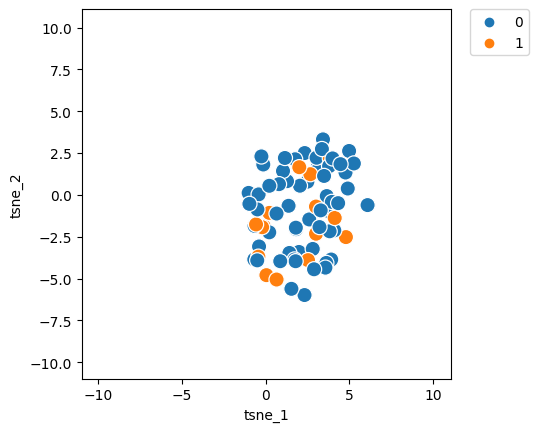

In [47]:
#concate_pred,d_out,phi=model()

data_orig=data.iloc[:,5:30]
labels=data.iloc[:,0]

# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components, random_state=42)
tsne_result = tsne.fit_transform(data_orig) #combined_features combined_transformed
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': labels})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [48]:
# wasserstein distance
loss1 = SamplesLoss(loss="sinkhorn", p=2, blur=.05)
t_zero=tsne_result[:,0]
t_one=tsne_result[:,1]

wasser = loss1(torch.unsqueeze(torch.from_numpy(t_zero.astype(np.float32)),dim=1),torch.unsqueeze(torch.from_numpy(t_one.astype(np.float32)),dim=1))

In [49]:
wasser

tensor(4.9106)

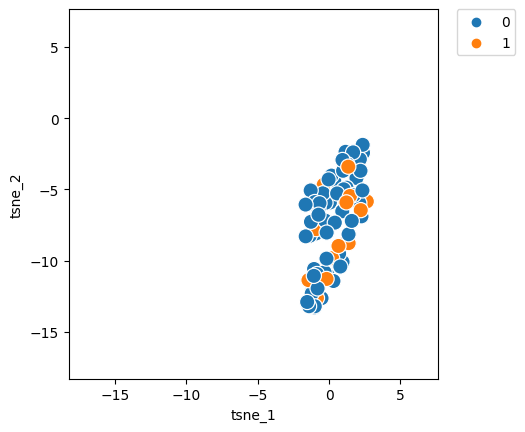

In [50]:
data_for_trans=data.iloc[:,5:30]
labels_for_trans=data.iloc[:,0]

data_tensor=torch.from_numpy(data_for_trans.to_numpy().astype(np.float32))
concate_pred,d_out,phi=model(data_tensor,0.5)

#data=data[:,5:30]
#labels=data[:,0]

# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components,random_state=42)
tsne_result_tr = tsne.fit_transform(phi.detach().cpu().numpy()) #combined_features combined_transformed
tsne_result_df_tr = pd.DataFrame({'tsne_1': tsne_result_tr[:,0], 'tsne_2': tsne_result_tr[:,1], 'label': labels_for_trans})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df_tr, ax=ax,s=120)
lim = (tsne_result_tr.min()-5, tsne_result_tr.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [51]:
# wasserstein distance
loss1 = SamplesLoss(loss="sinkhorn", p=2, blur=.05)
t_zero_tr=tsne_result_tr[:,0]
t_one_tr=tsne_result_tr[:,1]
wasser_tr = loss1(torch.unsqueeze(torch.from_numpy(t_zero_tr.astype(np.float32)),dim=1),torch.unsqueeze(torch.from_numpy(t_one_tr.astype(np.float32)),dim=1))

In [52]:
wasser_tr

tensor(31.7009)

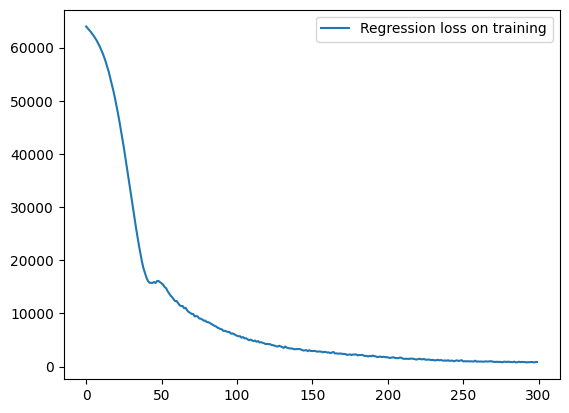

In [102]:
plt.plot(train_loss, label='Regression loss on training')
#plt.plot(val_loss, label='Regression loss on validation')
plt.legend()
plt.show()

In [141]:
'''
full network origional with optuna

class TarNet(nn.Module):
    def __init__(self,params):
        super(TarNet, self).__init__()
        self.encoder1 = nn.Linear(25, params['RL11'])
        self.encoder2 = nn.Linear(params['RL11'], params['RL21'])
        self.encoder3 = nn.Linear(params['RL21'], params['RL32'])
        
        self.dis1_d = nn.Sequential(
            nn.Linear(params['RL32'], params['CL12']), #params['CL12']
            nn.ReLU(),
            nn.Dropout(p=0.1)
        )
        self.dis2_d = nn.Sequential(
            nn.Linear(params['CL12'], params['CL22']), #
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
        
        self.dis3_d = nn.Sequential(
            nn.Linear(params['CL22'], 2),
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
       
        
        self.regressor1_y0 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG012']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y0 = nn.Sequential(
            nn.Linear(params['RG012'], params['RG022']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y0 = nn.Linear(params['RG022'], 1)

        self.regressor1_y1 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG112']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y1 = nn.Sequential(
            nn.Linear(params['RG112'], params['RG122']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y1 = nn.Linear(params['RG122'], 1)



    def forward(self, inputs,alpha=0.5):
        x = nn.functional.elu(self.encoder1(inputs))
        phi= nn.functional.elu(self.encoder2(x))
        phi = nn.functional.elu(self.encoder3(phi))
        
        out_y0 = self.regressor1_y0(phi)
        out_y0 = self.regressor2_y0(out_y0)
        y0 = self.regressorO_y0(out_y0)

        out_y1 = self.regressor1_y1(phi)
        out_y1 = self.regressor2_y1(out_y1)
        y1 = self.regressorO_y1(out_y1)

        concat = torch.cat((y0, y1), 1)
        
        rev = ReverseLayerF.apply(phi, alpha)
        
        out_d1 = self.dis1_d(rev)
        out_d2 = self.dis2_d(out_d1)
        d_out = self.dis3_d(out_d2)

        concat = torch.cat((y0, y1), 1)
        return concat,d_out

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None
    
class GRL(Function):
    @staticmethod
    def forward(ctx, tensor, constant):
        ctx.constant = constant
        return tensor * constant
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.constant, None




def objective(trial,i):

    params = {
          'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
          'optimizer': trial.suggest_categorical("optimizer", ["Adam", "SGD"]),
          'batch_size':trial.suggest_int('batch_size', 8, 256),
          'RL11':trial.suggest_int('RL11', 16, 512),
          'RL21': trial.suggest_int('RL21', 16, 512),
          'RL32': trial.suggest_int('RL32', 16, 512),
          'RG012':trial.suggest_int('RG012', 16, 512),
        'RG022':trial.suggest_int('RG022', 16, 512),
        'RG112':trial.suggest_int('RG112', 16, 512),
        'RG122':trial.suggest_int('RG122', 16, 512),
        'CL12':trial.suggest_int('CL12', 16, 512),
        'CL22':trial.suggest_int('CL22', 16, 512)
          
          }

    model = TarNet(params)

    pehe,model= train_evaluate(params, model, trial,i)

    return pehe


'''

'\nfull network origional with optuna\n\nclass TarNet(nn.Module):\n    def __init__(self,params):\n        super(TarNet, self).__init__()\n        self.encoder1 = nn.Linear(25, params[\'RL11\'])\n        self.encoder2 = nn.Linear(params[\'RL11\'], params[\'RL21\'])\n        self.encoder3 = nn.Linear(params[\'RL21\'], params[\'RL32\'])\n        \n        self.dis1_d = nn.Sequential(\n            nn.Linear(params[\'RL32\'], params[\'CL12\']), #params[\'CL12\']\n            nn.ReLU(),\n            nn.Dropout(p=0.1)\n        )\n        self.dis2_d = nn.Sequential(\n            nn.Linear(params[\'CL12\'], params[\'CL22\']), #\n            nn.ReLU(),\n            nn.Dropout(p=.01)\n        )\n        \n        self.dis3_d = nn.Sequential(\n            nn.Linear(params[\'CL22\'], 2),\n            nn.ReLU(),\n            nn.Dropout(p=.01)\n        )\n       \n        \n        self.regressor1_y0 = nn.Sequential(\n            nn.Linear(params[\'RL32\'], params[\'RG012\']),\n            nn.ELU()

In [ ]:
'''
Library way: all networks have two layers 
1.38

class TarNet(nn.Module):
    def __init__(self,params):
        super(TarNet, self).__init__()
        self.encoder1 = nn.Linear(25, params['RL11'])
        self.encoder2 = nn.Linear(params['RL11'], params['RL21'])
        self.encoder3 = nn.Linear(params['RL21'], params['RL32'])
        
        self.dis1_d = nn.Sequential(
            nn.Linear(params['RL21'], params['CL12']), #params['CL12']
            nn.ReLU(),
            nn.Dropout(p=0.1)
        )
        self.dis2_d = nn.Sequential(
            nn.Linear(params['CL12'], 2), #params['CL22']
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
        
        self.dis3_d = nn.Sequential(
            nn.Linear(params['CL22'], 2),
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
       
        
        self.regressor1_y0 = nn.Sequential(
            nn.Linear(params['RL21'], params['RG012']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y0 = nn.Sequential(
            nn.Linear(params['RG012'], 1),#params['RG022']
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y0 = nn.Linear(params['RG022'], 1)

        self.regressor1_y1 = nn.Sequential(
            nn.Linear(params['RL21'], params['RG112']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y1 = nn.Sequential(
            nn.Linear(params['RG112'], 1), #params['RG122']
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y1 = nn.Linear(params['RG122'], 1)



    def forward(self, inputs,alpha=0.5):
        x = nn.functional.elu(self.encoder1(inputs))
        phi= nn.functional.elu(self.encoder2(x))
        #phi = nn.functional.elu(self.encoder3(phi))
        
        out_y0 = self.regressor1_y0(phi)
        out_y0 = self.regressor2_y0(out_y0)
        #y0 = self.regressorO_y0(out_y0)

        out_y1 = self.regressor1_y1(phi)
        out_y1 = self.regressor2_y1(out_y1)
        #y1 = self.regressorO_y1(out_y1)

        #concat = torch.cat((y0, y1), 1)
        
        rev = ReverseLayerF.apply(phi, alpha)
        
        out_d1 = self.dis1_d(rev)
        out_d2 = self.dis2_d(out_d1)
        #d_out = self.dis3_d(out_d2)

        concat = torch.cat((out_y0, out_y1), 1)
        return concat,out_d2

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None
    
class GRL(Function):
    @staticmethod
    def forward(ctx, tensor, constant):
        ctx.constant = constant
        return tensor * constant
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.constant, None

'''



In [ ]:
'''
Tutorial way: layers and neurons all changed

class TarNet(nn.Module):
    def __init__(self,params):
        super(TarNet, self).__init__()
        self.encoder1 = nn.Linear(25, params['RL11'])
        self.encoder2 = nn.Linear(params['RL11'], params['RL21'])
        self.encoder3 = nn.Linear(params['RL21'], params['RL32'])
        
        self.dis1_d = nn.Sequential(
            nn.Linear(params['RL32'], params['CL12']), #params['CL12']
            nn.ReLU(),
            nn.Dropout(p=0.1)
        )
        self.dis2_d = nn.Sequential(
            nn.Linear(params['CL12'], params['CL22']), #
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
        
        self.dis3_d = nn.Sequential(
            nn.Linear(params['CL22'], 2),
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
       
        
        self.regressor1_y0 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG012']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y0 = nn.Sequential(
            nn.Linear(params['RG012'], 1), #params['RG022']
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y0 = nn.Linear(params['RG022'], 1)

        self.regressor1_y1 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG112']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y1 = nn.Sequential(
            nn.Linear(params['RG112'], 1), #params['RG122']
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y1 = nn.Linear(params['RG122'], 1)



    def forward(self, inputs,alpha=0.5):
        x = nn.functional.elu(self.encoder1(inputs))
        phi= nn.functional.elu(self.encoder2(x))
        #phi = nn.functional.elu(self.encoder3(phi))
        
        out_y0 = self.regressor1_y0(phi)
        out_y0 = self.regressor2_y0(out_y0)
        #y0 = self.regressorO_y0(out_y0)

        out_y1 = self.regressor1_y1(phi)
        out_y1 = self.regressor2_y1(out_y1)
        #y1 = self.regressorO_y1(out_y1)

        concat = torch.cat((y0, y1), 1)
        
        rev = ReverseLayerF.apply(phi, alpha)
        
        out_d1 = self.dis1_d(rev)
        out_d2 = self.dis2_d(out_d1)
        d_out = self.dis3_d(out_d2)

        concat = torch.cat((out_y0, out_y1), 1)
        return concat,d_out

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None
    
class GRL(Function):
    @staticmethod
    def forward(ctx, tensor, constant):
        ctx.constant = constant
        return tensor * constant
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.constant, None




def objective(trial,i):

    params = {
          'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
          'optimizer': trial.suggest_categorical("optimizer", ["Adam", "SGD"]),
          'batch_size':trial.suggest_int('batch_size', 8, 256),
          'RL11':trial.suggest_int('RL11', 16, 32),
          'RL21': trial.suggest_int('RL21', 16, 32),
          'RL32': trial.suggest_int('RL32', 16, 32),
          'RG012':trial.suggest_int('RG012', 16, 32),
        'RG022':trial.suggest_int('RG022', 16, 32),
        'RG112':trial.suggest_int('RG112', 16, 32),
        'RG122':trial.suggest_int('RG122', 16, 32),
        'CL12':trial.suggest_int('CL12', 16, 32),
        'CL22':trial.suggest_int('CL22', 16, 32)
          
          }

    model = TarNet(params)

    pehe,model= train_evaluate(params, model, trial,i)

    return pehe


'''

In [ ]:
'''
result 0.71 seed=42, result 0.79 seed=0, result 0.72 seed=1
one change: with 2 layers of classifier

class TarNet(nn.Module):
    def __init__(self,params):
        super(TarNet, self).__init__()
        self.encoder1 = nn.Linear(25, params['RL11'])
        self.encoder2 = nn.Linear(params['RL11'], params['RL21'])
        self.encoder3 = nn.Linear(params['RL21'], params['RL32'])
        
        self.dis1_d = nn.Sequential(
            nn.Linear(params['RL32'], params['CL12']), #params['CL12']
            nn.ReLU(),
            nn.Dropout(p=0.1)
        )
        self.dis2_d = nn.Sequential(
            nn.Linear(params['CL12'], 2), #params['CL22']
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
        
        self.dis3_d = nn.Sequential(
            nn.Linear(params['CL22'], 2),
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
       
        
        self.regressor1_y0 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG012']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y0 = nn.Sequential(
            nn.Linear(params['RG012'], params['RG022']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y0 = nn.Linear(params['RG022'], 1)

        self.regressor1_y1 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG112']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y1 = nn.Sequential(
            nn.Linear(params['RG112'], params['RG122']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y1 = nn.Linear(params['RG122'], 1)



    def forward(self, inputs,alpha=0.5):
        x = nn.functional.elu(self.encoder1(inputs))
        phi= nn.functional.elu(self.encoder2(x))
        phi = nn.functional.elu(self.encoder3(phi))
        
        out_y0 = self.regressor1_y0(phi)
        out_y0 = self.regressor2_y0(out_y0)
        y0 = self.regressorO_y0(out_y0)

        out_y1 = self.regressor1_y1(phi)
        out_y1 = self.regressor2_y1(out_y1)
        y1 = self.regressorO_y1(out_y1)

        #concat = torch.cat((y0, y1), 1)
        
        rev = ReverseLayerF.apply(phi, alpha)
        
        out_d1 = self.dis1_d(rev)
        out_d2 = self.dis2_d(out_d1)
        #d_out = self.dis3_d(out_d2)

        concat = torch.cat((y0, y1), 1)
        return concat,out_d2

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None
    
class GRL(Function):
    @staticmethod
    def forward(ctx, tensor, constant):
        ctx.constant = constant
        return tensor * constant
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.constant, None


'''